<a href="https://colab.research.google.com/github/georgesolis/portafolio/blob/main/Campa%C3%B1a_Mkt_Mailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Caso N°1 - Campaña de Marketing**


---

Una empresa "X" tiene presupuestado una campaña de marketing en donde desean enviar correos masivos a una base de clientes, sin embargo para mejorar la conversión y optimizar el presupuesto, se busca priorizar a los clientes que tenga mayor probabilidad de conversión mediante mail. Se cuenta con una base de datos histórica en donde se indica que clientes abrieron el mail y que clientes no abrieron el mail.

El proyecto necesita que, mediante el uso de analìtica de datos y machine learning, perfilemos el grupo de clientes que tenga mayor probabilidad de abrir el correo. 


---

*   Población objetivo: Clientes que abrieron el mail.
*   Unidad de análisis: Cliente

In [ ]:
#Instalar los paquetes necesarios:
#!pip install "pycaret[full]"
#!pip install sweetviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import types
import matplotlib.mlab as mlab
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import sweetviz
import seaborn as sns
import time 
from datetime import date
from datetime import timedelta

In [2]:
# Cargamos el dataset
data = pd.read_csv('campana-Marketing.csv')
data.head()

,CLIENTE,EDAD,ANIOS_AFILIACION,ESTADO_CIVIL,SEXO,CPM,TP,TXTS,MEDIO_PAGO,TARGET
0,1,62,3,C,M,405,27,15,Efectivo,0
1,2,60,8,C,F,387,85,5,tc,1
2,3,59,7,C,F,366,44,8,tc,1
3,4,47,8,S,M,244,244,1,Efectivo,0
4,5,44,8,S,F,629,173,4,tc,1


**Análisis exploratorio de datos**

In [3]:
eda_obj= sweetviz.analyze(data)

eda_obj.show_html('EDA_CAMPANA_MKT' + '.html', layout='widescreen', scale = 0.8)

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_CAMPANA_MKT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [4]:
data.columns.values

array(['CLIENTE', 'EDAD', 'ANIOS_AFILIACION', 'ESTADO_CIVIL', 'SEXO',
       'CPM', 'TP', 'TXTS', 'MEDIO_PAGO', 'TARGET'], dtype=object)

In [5]:
cat = data[['ESTADO_CIVIL','SEXO','MEDIO_PAGO']]

In [6]:
cat.describe(include='all').transpose()

,count,unique,top,freq
ESTADO_CIVIL,500,4,C,292
SEXO,500,2,F,292
MEDIO_PAGO,500,3,tc,258


In [7]:
num = data[['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']]
num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EDAD,500.0,50.442,14.436046,18.0,39.0,49.0,61.00,90.0
ANIOS_AFILIACION,500.0,5.248,2.450818,0.0,3.0,6.0,7.00,8.0
CPM,500.0,368.688,306.928730,11.0,177.0,275.5,471.25,2879.0
TP,500.0,82.864,68.653070,6.0,37.0,63.0,105.00,459.0
TXTS,500.0,6.286,5.990658,1.0,3.0,4.0,8.00,54.0


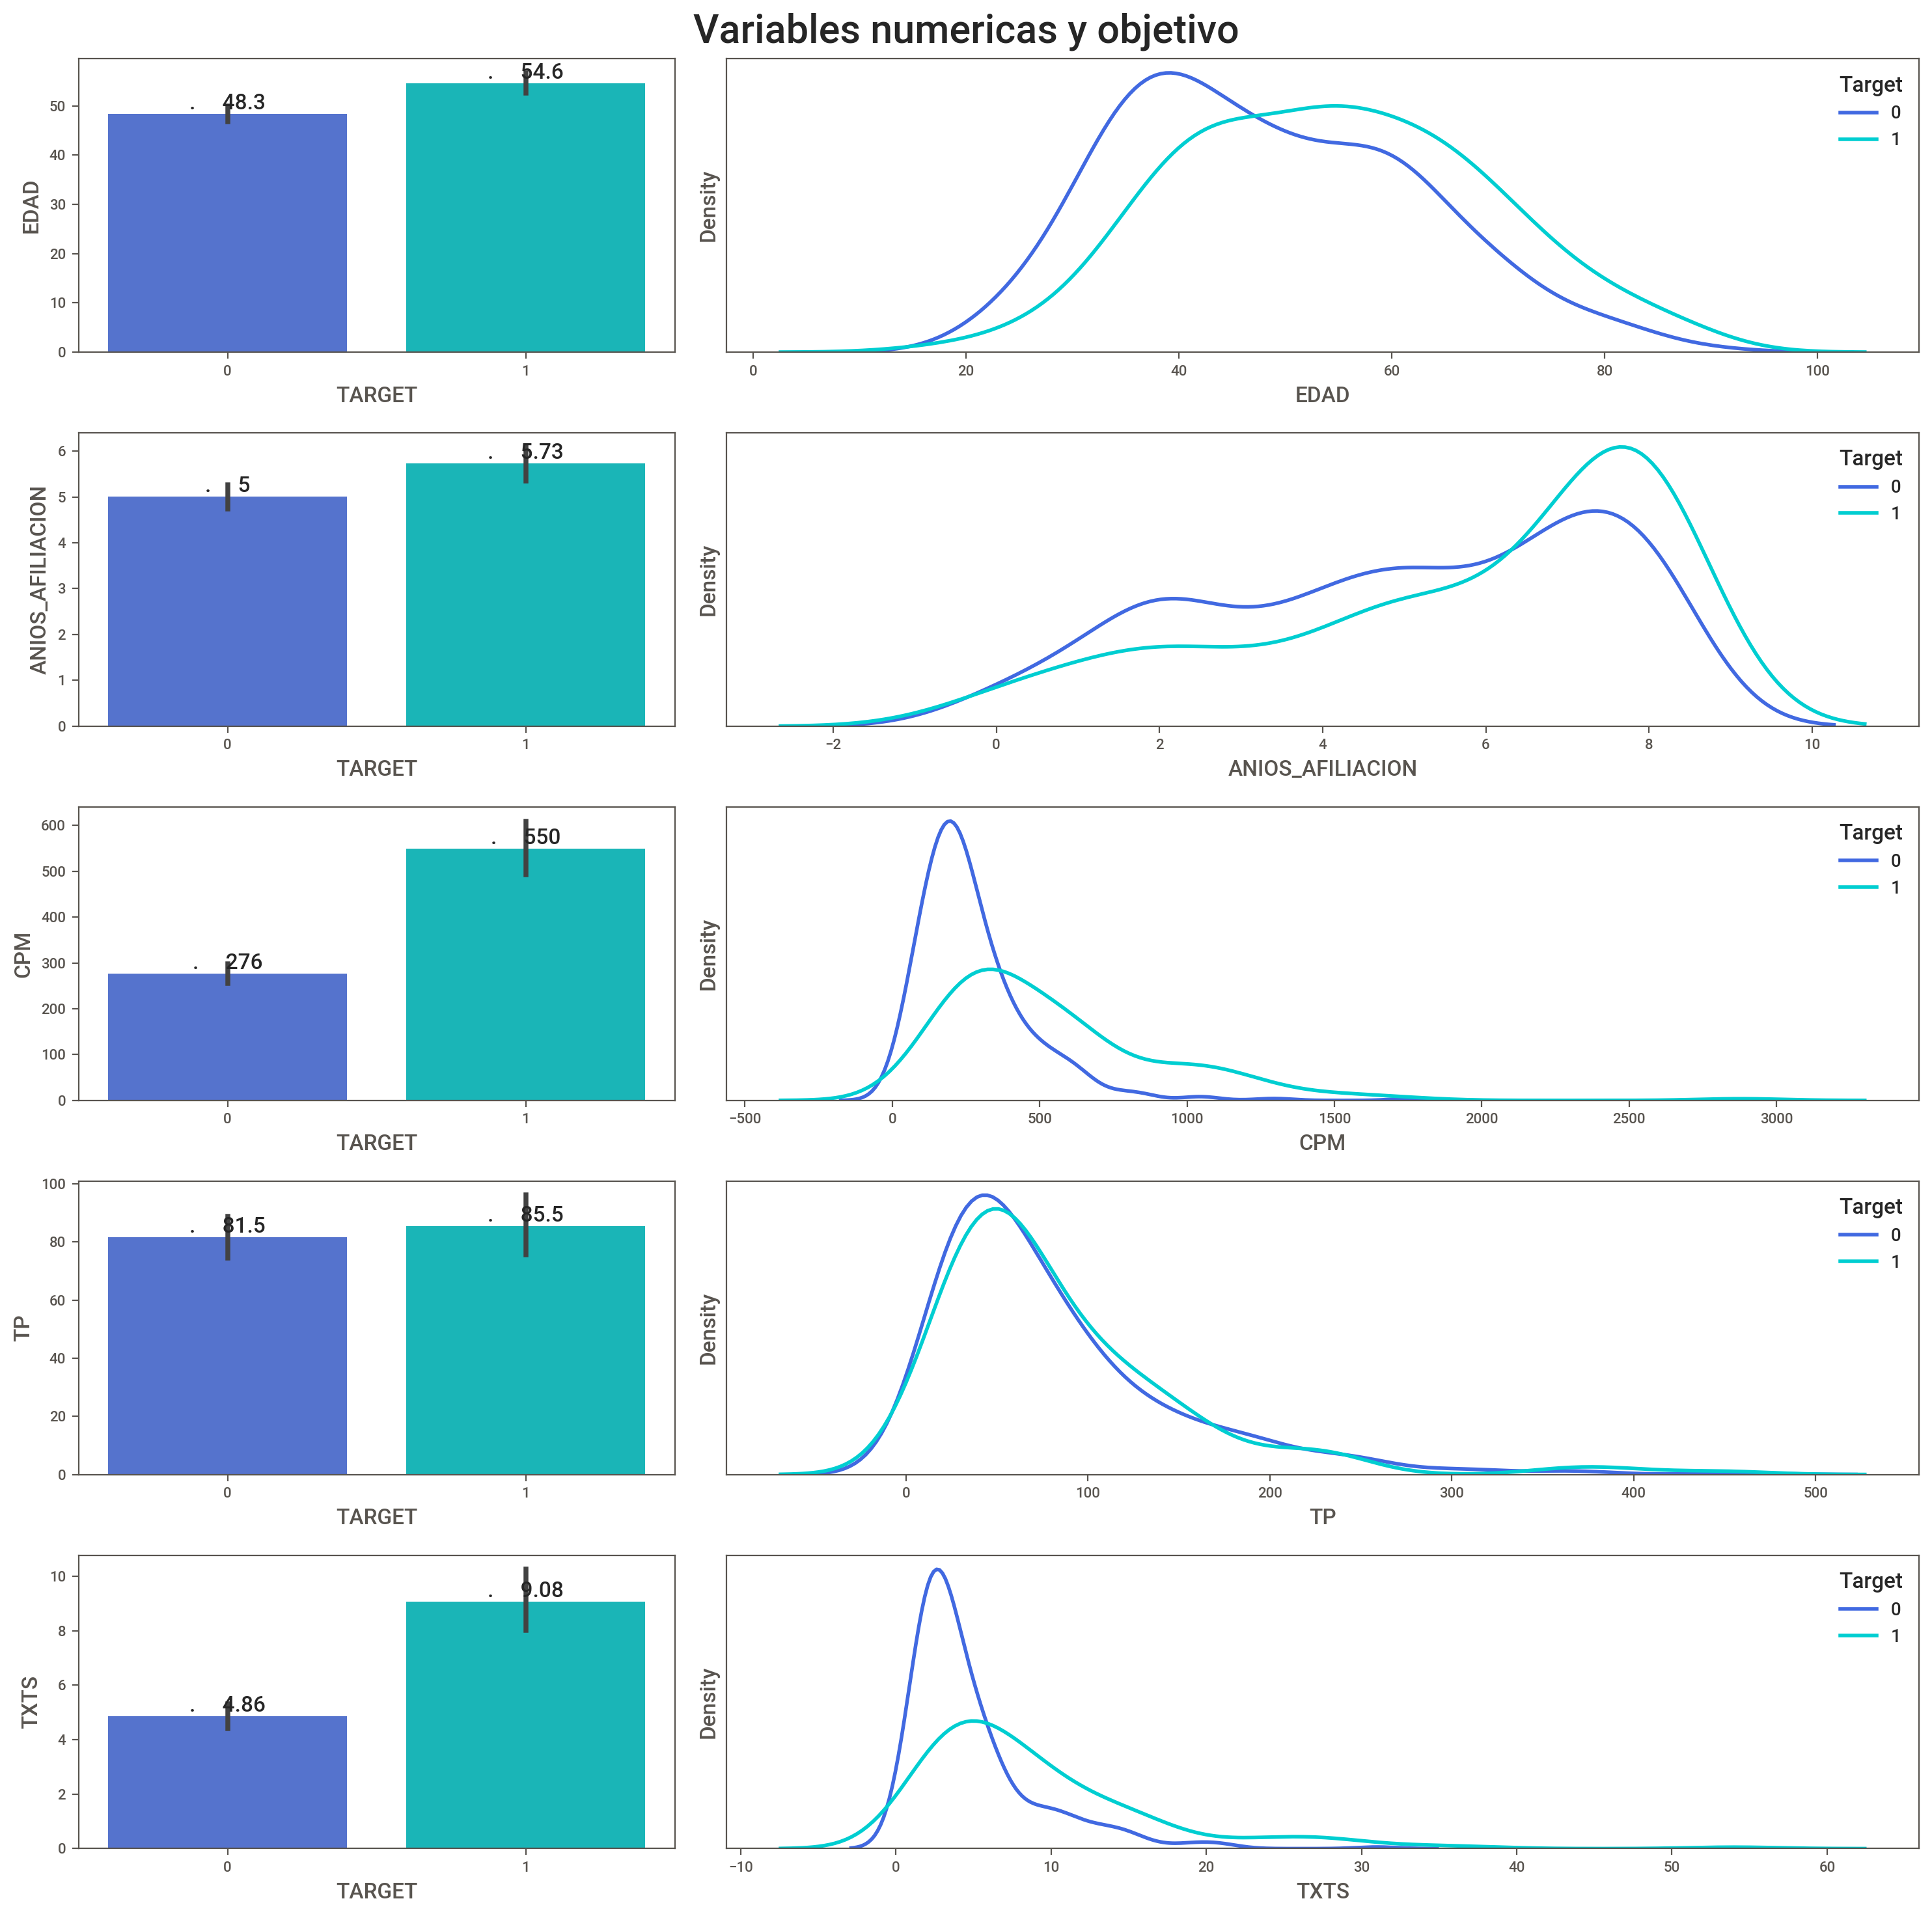

In [8]:
objetivo = 'TARGET'
Num_Features = ['EDAD', 'ANIOS_AFILIACION','CPM', 'TP', 'TXTS']

sns.set_palette(['royalblue','darkturquoise'])
fig, ax = plt.subplots(5,2,figsize=(15,15),dpi=200,gridspec_kw={'width_ratios': [1,2]})
for i,col in enumerate(Num_Features):
    #barplot
    graph = sns.barplot(data=data,x=objetivo, y=col, ax=ax[i,0])
    #kde PLOT
    sns.kdeplot(data=data[data[objetivo]==0],x=col, linewidth=2, ax=ax[i,1],label='0')
    sns.kdeplot(data=data[data[objetivo]==1],x=col, linewidth=2, ax=ax[i,1],label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title="Target",loc='upper right')
    #add bar sizes to our plot
    for cont in graph.containers:
      graph.bar_label(cont, fmt='.     %.3g')

plt.suptitle('Variables numericas y objetivo', fontsize=22)
plt.tight_layout()
plt.show()

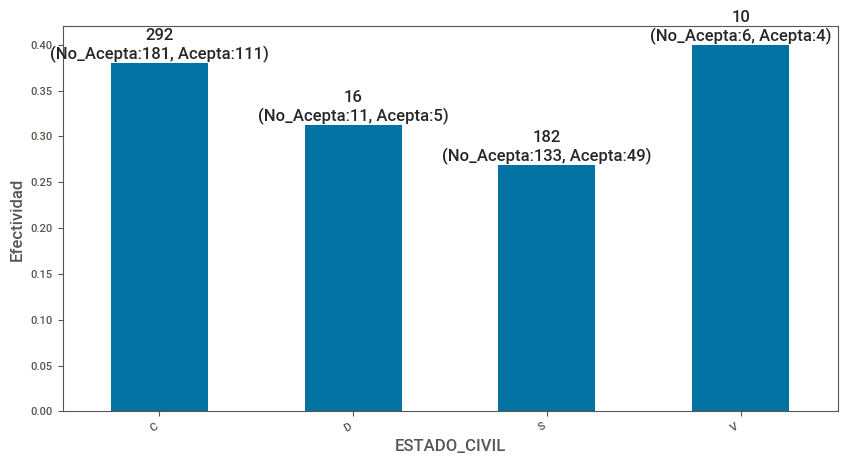

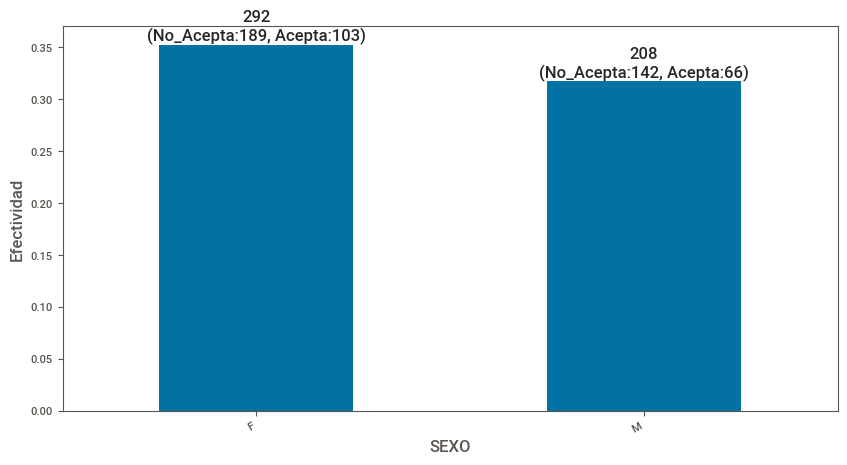

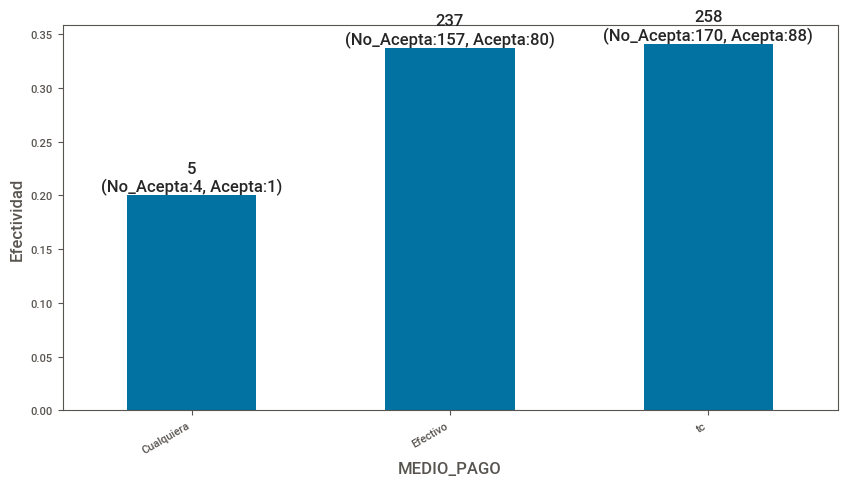

In [9]:
cat_features = ['ESTADO_CIVIL','SEXO','MEDIO_PAGO']
for i in cat_features:
    resumen = pd.concat([data[data.TARGET == 0].groupby(i).TARGET.count()
                          , data[data.TARGET == 1].groupby(i).TARGET.count()], axis=1)
    resumen.columns = ['No_Acepta','Acepta']
    resumen_f = resumen.Acepta / (resumen.Acepta + resumen.No_Acepta)
    plt.figure(figsize=(10,5))
    ax = resumen_f.plot(kind='bar', color='b')
    ax.set_xticklabels(resumen_f.index, rotation=30, fontsize=8, ha='right')
    ax.set_xlabel(i)
    ax.set_ylabel('Efectividad')
    
    # Agregar etiquetas de cantidad de datos
    for j, (valor_acepta, valor_no_acepta) in enumerate(zip(resumen.Acepta, resumen.No_Acepta)):
        total_datos = valor_acepta + valor_no_acepta
        ax.annotate(f'{total_datos}\n(No_Acepta:{valor_no_acepta}, Acepta:{valor_acepta})', xy=(j, resumen_f[j]), ha='center', va='bottom')


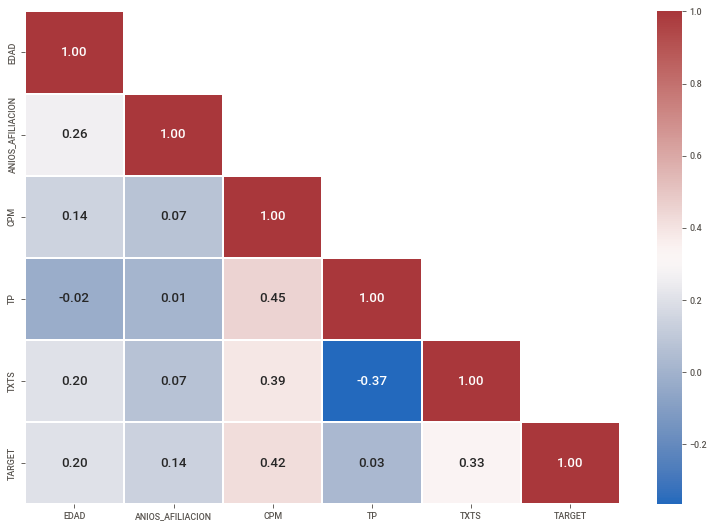

In [10]:
df = data.drop('CLIENTE', axis=1)
#Calculo de Correlación
corr = df.corr(method='pearson')

#Creamos una mascara para ver la correlación en un solo lado
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)]=True

#Plot the heatmap correlation
plt.figure(figsize=(12,8),dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap = 'vlag', fmt='.2f', linewidths=0.2)
plt.show()

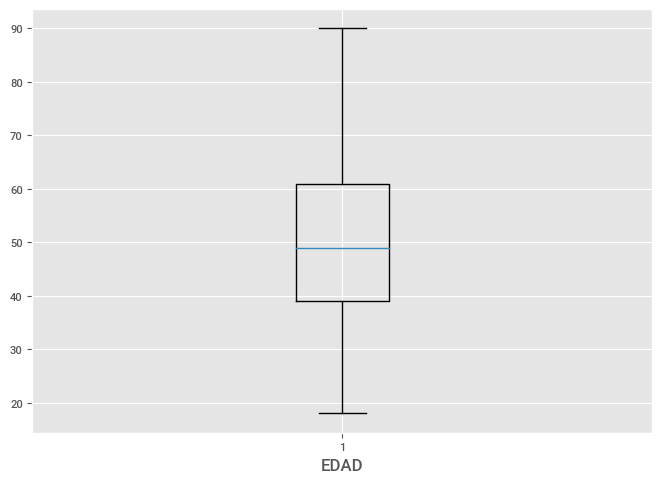

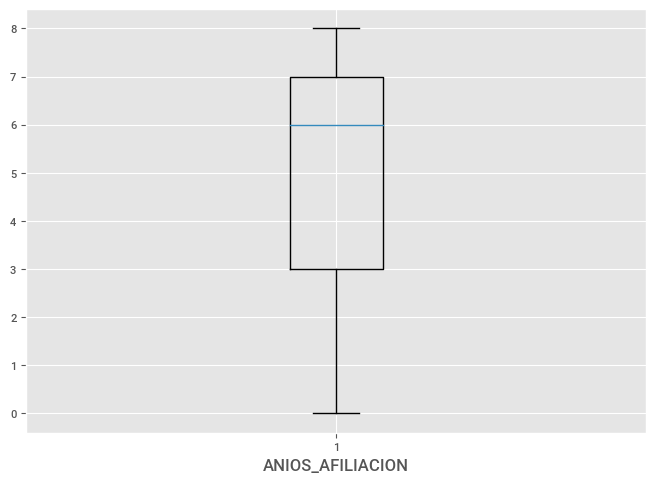

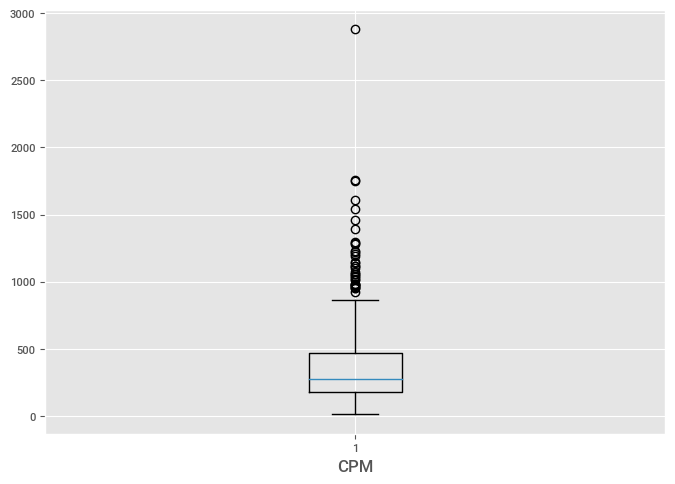

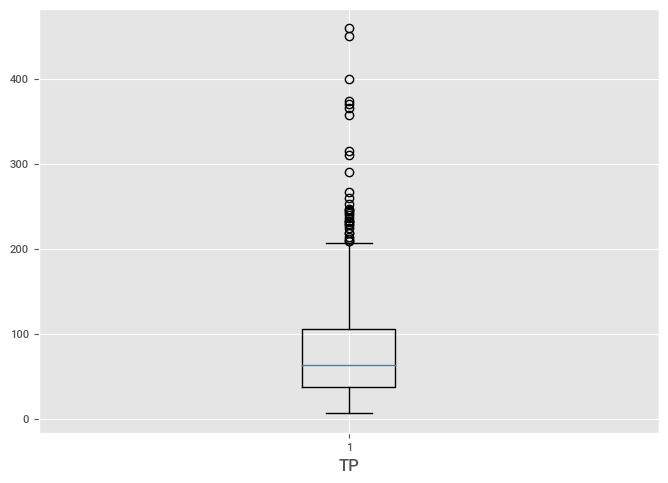

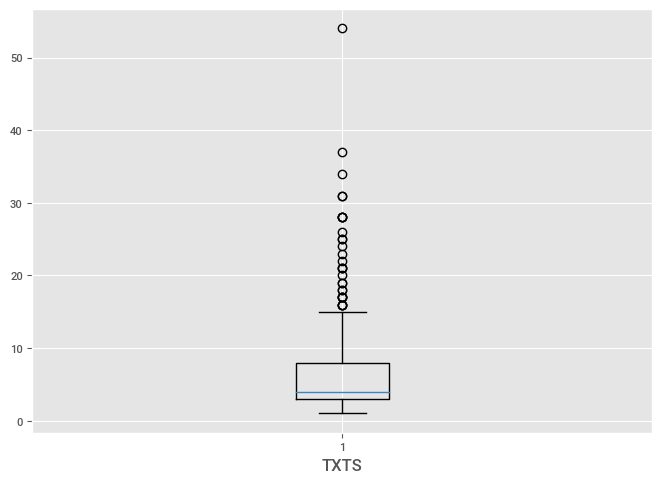

In [11]:
plt.style.use('ggplot')

for i in Num_Features:
    plt.boxplot(data[i])
    plt.xlabel(i)
    plt.show()

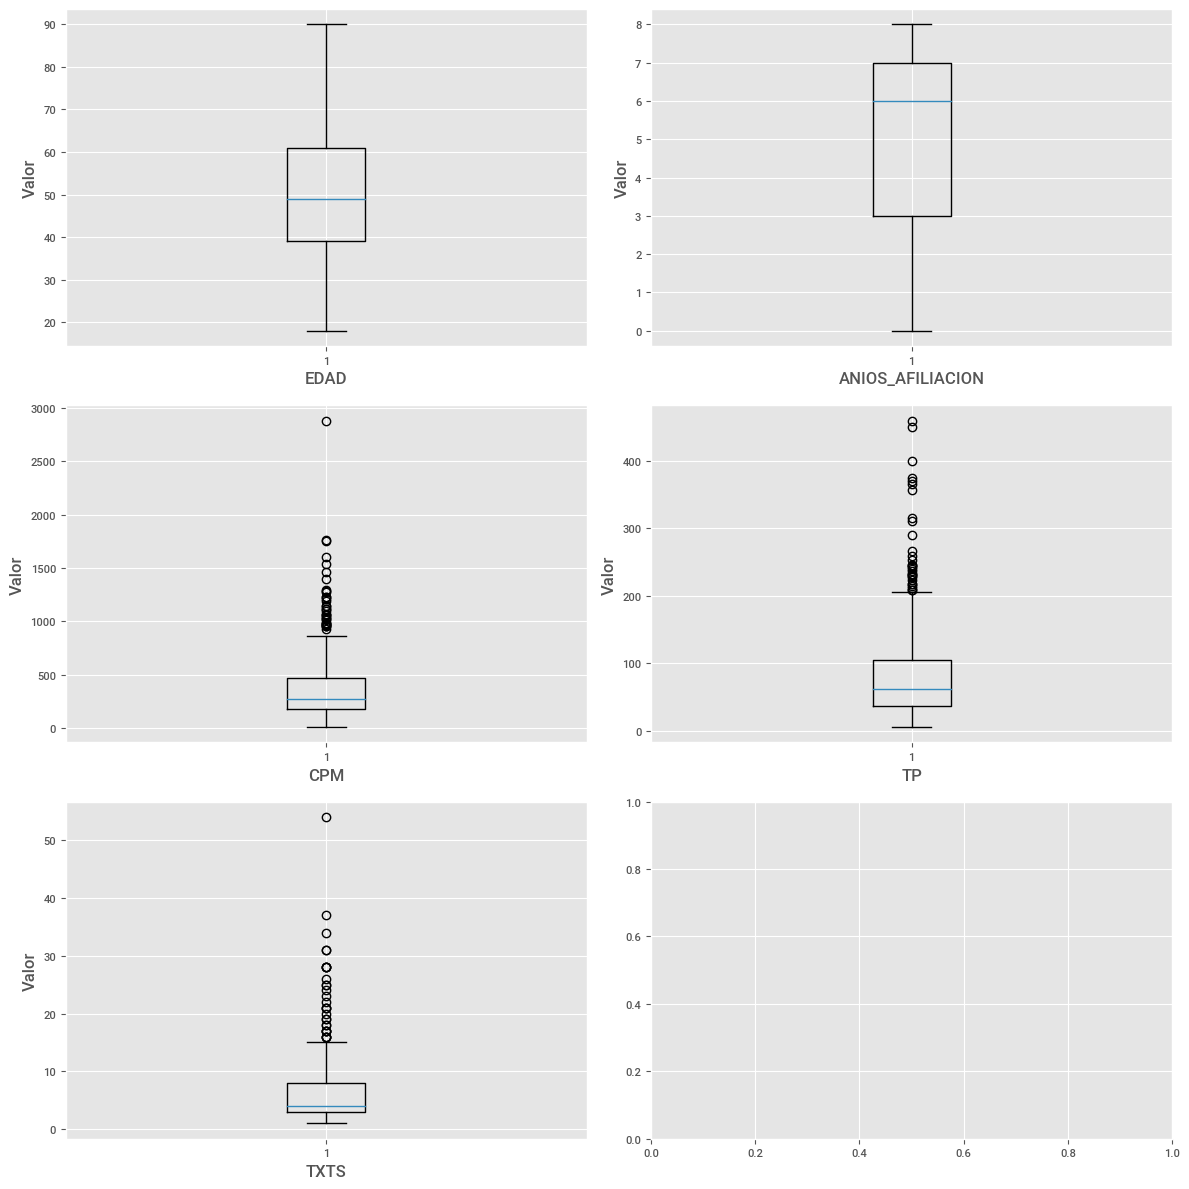

In [12]:
plt.style.use('ggplot')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for i, feature in enumerate(Num_Features):
    ax = axs[i // 2, i % 2]  # Obtener la subtrama actual correctamente
    ax.boxplot(data[feature])
    ax.set_xlabel(feature)
    ax.set_ylabel('Valor')
    #ax.set_title(feature)

plt.tight_layout()  # Ajustar el espaciado entre subtramas
plt.show()


Calculamos el coeficiente de asimetría y coeficiente de variación

In [13]:
from scipy import stats 
import pandas as pd


data_ca = {'Variable' : Num_Features,
       'Coeficiente_Asim' : stats.skew(data[Num_Features])}
asim = pd.DataFrame(data_ca)
asim

,Variable,Coeficiente_Asim
0,EDAD,0.299534
1,ANIOS_AFILIACION,-0.517769
2,CPM,2.587872
3,TP,2.075812
4,TXTS,2.758936


In [14]:
res_data_num = data[Num_Features].describe().transpose()
res_data_num['cv'] = res_data_num.iloc[:,2] / res_data_num.iloc[:,1] * 100
res_data_num

,count,mean,std,min,25%,50%,75%,max,cv
EDAD,500.0,50.442,14.436046,18.0,39.0,49.0,61.00,90.0,28.619100
ANIOS_AFILIACION,500.0,5.248,2.450818,0.0,3.0,6.0,7.00,8.0,46.700039
CPM,500.0,368.688,306.928730,11.0,177.0,275.5,471.25,2879.0,83.248907
TP,500.0,82.864,68.653070,6.0,37.0,63.0,105.00,459.0,82.850297
TXTS,500.0,6.286,5.990658,1.0,3.0,4.0,8.00,54.0,95.301586


**Modelado con PYCARET**

In [15]:
np.seterr(divide = 'ignore', invalid = 'ignore')
s = setup(data,
          target = 'TARGET',
          imputation_type = 'iterative',
          n_jobs=-1,
          remove_outliers = True,
          ignore_features = ['CLIENTE'],
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(500, 10)"
4,Transformed data shape,"(482, 14)"
5,Transformed train set shape,"(332, 14)"
6,Transformed test set shape,"(150, 14)"
7,Ignore features,1
8,Ordinal features,1
9,Numeric features,5


In [16]:
(get_config('y_train').value_counts())/len(get_config('y_train')) *100

0    66.285714
1    33.714286
Name: TARGET, dtype: float64

In [17]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [19]:
%%time

best = compare_models(sort='f1',
                      fold=10,
                      #include=['dt','rf','lr'],
                      n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7657,0.7746,0.5182,0.7123,0.5968,0.4382,0.4510,0.4830
knn,K Neighbors Classifier,0.7429,0.7192,0.5250,0.6509,0.5760,0.3955,0.4027,0.5860
lda,Linear Discriminant Analysis,0.7543,0.7749,0.4591,0.7107,0.5571,0.3983,0.4167,0.4580
nb,Naive Bayes,0.6229,0.7097,0.6470,0.5426,0.5569,0.2697,0.2630,0.2280
catboost,CatBoost Classifier,0.7400,0.7289,0.4932,0.6517,0.5551,0.3794,0.3895,2.2860
ada,Ada Boost Classifier,0.7171,0.7141,0.5098,0.6067,0.5479,0.3458,0.3525,0.4410
ridge,Ridge Classifier,0.7543,0.0000,0.4424,0.7244,0.5476,0.3930,0.4161,0.1760
gbc,Gradient Boosting Classifier,0.7171,0.7270,0.4841,0.6140,0.5363,0.3374,0.3455,0.4820
rf,Random Forest Classifier,0.7114,0.7297,0.4758,0.5902,0.5232,0.3211,0.3267,0.7560
lightgbm,Light Gradient Boosting Machine,0.6971,0.6972,0.4939,0.5565,0.5172,0.3007,0.3048,0.2820


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

CPU times: user 12.9 s, sys: 1.04 s, total: 13.9 s
Wall time: 1min 38s


In [22]:
#Capturamos el resultado de la evaluación inicial
best_resumen = pull()
fecha = date.today()
fecha = fecha.strftime("%Y%m%d")
best_resumen.to_excel('resultados_Mod'+fecha+'.xlsx')

In [139]:
#revisamos a detalle los mejores modelos
mod = best[0]
evaluate_model(mod)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [24]:
#Exportamos gràficos del modelo optimizado
plot_model(mod, plot = 'feature',save=True)
plot_model(mod, plot = 'feature_all',save=True)
plot_model(mod, plot = 'confusion_matrix',save=True)
plot_model(mod, plot = 'auc',save=True)
plot_model(mod, plot = 'class_report',save=True)

'Class Report.png'

In [27]:
#predicciones
predict_model(mod)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7667,0.7396,0.4118,0.8077,0.5455,0.4100,0.4521


ValueError: ignored

In [28]:
#finaliza entrenamiento
modelo_final = finalize_model(mod)
save_model(modelo_final, 'modelo_propension_v1')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('iterative_imputer',
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=IterativeImputer(add_indicator=False,
                                                                  cat_estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                               class_weight=None,
                                                                                               colsample_bytree=1.0,
                                                                                               importance_type='split',
                                                                                               learning_rate=0.1,
                                                                                               max_depth=-1,
                                                                   

**Producción**

In [29]:
ruta_modelo = r'modelo_propension_v1'
modelo = load_model(ruta_modelo)

Transformation Pipeline and Model Successfully Loaded


In [30]:
data = {
    'CLIENTE': [1, 2, 3, 4, 5],
    'EDAD': [62, 60, 59, 47, 44],
    'ANIOS_AFILIACION': [3, 8, 7, 8, 8],
    'ESTADO_CIVIL': ['C', 'C', 'C', 'S', 'S'],
    'SEXO': ['M', 'F', 'F', 'M', 'F'],
    'CPM': [405, 387, 366, 244, 629],
    'TP': [27, 85, 44, 244, 173],
    'TXTS': [15, 5, 8, 1, 4],
    'MEDIO_PAGO': ['Efectivo', 'tc', 'tc', 'Efectivo', 'tc']
}

df = pd.DataFrame(data)

In [31]:
#ejecutamos prediccion
predicciones = predict_model(modelo,raw_score=True, data=df)

In [32]:
#Seleeciono las columnas que necesito (Cliente, predicción de conversión, probabilidad)
dfp = predicciones[['CLIENTE','prediction_label','prediction_score_1']]

In [33]:
#Muestra de clientes
dfp.head(5)

,CLIENTE,prediction_label,prediction_score_1
0,1,1,0.5011
1,2,0,0.4593
2,3,1,0.5070
3,4,0,0.0669
4,5,0,0.4879


## MÉTODO 2:

In [35]:
# Cargamos el dataset
data = pd.read_csv('campana-Marketing.csv')
data.head()

,CLIENTE,EDAD,ANIOS_AFILIACION,ESTADO_CIVIL,SEXO,CPM,TP,TXTS,MEDIO_PAGO,TARGET
0,1,62,3,C,M,405,27,15,Efectivo,0
1,2,60,8,C,F,387,85,5,tc,1
2,3,59,7,C,F,366,44,8,tc,1
3,4,47,8,S,M,244,244,1,Efectivo,0
4,5,44,8,S,F,629,173,4,tc,1


In [36]:
import pandas
# One-hot encode categorical features
data = pandas.get_dummies(data, columns=["ESTADO_CIVIL", "SEXO","MEDIO_PAGO"], drop_first=False)

print(data.head())

   CLIENTE  EDAD  ANIOS_AFILIACION  CPM   TP  TXTS  TARGET  ESTADO_CIVIL_C  \
0        1    62                 3  405   27    15       0               1   
1        2    60                 8  387   85     5       1               1   
2        3    59                 7  366   44     8       1               1   
3        4    47                 8  244  244     1       0               0   
4        5    44                 8  629  173     4       1               0   

   ESTADO_CIVIL_D  ESTADO_CIVIL_S  ESTADO_CIVIL_V  SEXO_F  SEXO_M  \
0               0               0               0       0       1   
1               0               0               0       1       0   
2               0               0               0       1       0   
3               0               1               0       0       1   
4               0               1               0       1       0   

   MEDIO_PAGO_Cualquiera  MEDIO_PAGO_Efectivo  MEDIO_PAGO_tc  
0                      0                    1        

In [38]:
data.columns.values

array(['CLIENTE', 'EDAD', 'ANIOS_AFILIACION', 'CPM', 'TP', 'TXTS',
       'TARGET', 'ESTADO_CIVIL_C', 'ESTADO_CIVIL_D', 'ESTADO_CIVIL_S',
       'ESTADO_CIVIL_V', 'SEXO_F', 'SEXO_M', 'MEDIO_PAGO_Cualquiera',
       'MEDIO_PAGO_Efectivo', 'MEDIO_PAGO_tc'], dtype=object)

In [39]:
cliente_col = data['CLIENTE']
target_col = data['TARGET']

In [40]:
df = data.drop(['CLIENTE', 'TARGET'], axis=1)

In [41]:
df.head()

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc
0,62,3,405,27,15,1,0,0,0,0,1,0,1,0
1,60,8,387,85,5,1,0,0,0,1,0,0,0,1
2,59,7,366,44,8,1,0,0,0,1,0,0,0,1
3,47,8,244,244,1,0,0,1,0,0,1,0,1,0
4,44,8,629,173,4,0,0,1,0,1,0,0,0,1


In [42]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(df)
transformer
RobustScaler()

RobustScaler(copy=True, quantile_range=(25.0, 75.0), unit_variance=False,
             with_centering=True, with_scaling=True)

In [43]:
data_inputs_s = transformer.transform(df)

In [44]:
inputs = df.columns.tolist()

In [45]:
import pandas as pd
data_inputs_s = pd.DataFrame(data_inputs_s,columns=inputs)

In [46]:
data_inputs_s.head(3)

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc
0,0.590909,-0.75,0.440102,-0.529412,2.2,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0
1,0.500000,0.50,0.378929,0.323529,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.454545,0.25,0.307562,-0.279412,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
data_inputs_s['TARGET'] = target_col

In [49]:
data_inputs_s.head()

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc,TARGET
0,0.590909,-0.75,0.440102,-0.529412,2.2,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0
1,0.500000,0.50,0.378929,0.323529,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.454545,0.25,0.307562,-0.279412,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.090909,0.50,-0.107052,2.661765,-0.6,-1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0
4,-0.227273,0.50,1.201359,1.617647,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [57]:
import pandas as pd

data_fin = data_inputs_s.copy()

In [58]:
data_fin.head()

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc,TARGET
0,0.590909,-0.75,0.440102,-0.529412,2.2,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0
1,0.500000,0.50,0.378929,0.323529,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.454545,0.25,0.307562,-0.279412,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.090909,0.50,-0.107052,2.661765,-0.6,-1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0
4,-0.227273,0.50,1.201359,1.617647,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [67]:
data_fin.columns.values

array(['EDAD', 'ANIOS_AFILIACION', 'CPM', 'TP', 'TXTS', 'ESTADO_CIVIL_C',
       'ESTADO_CIVIL_D', 'ESTADO_CIVIL_S', 'ESTADO_CIVIL_V', 'SEXO_F',
       'SEXO_M', 'MEDIO_PAGO_Cualquiera', 'MEDIO_PAGO_Efectivo',
       'MEDIO_PAGO_tc', 'TARGET'], dtype=object)

In [107]:
X = data_fin[['EDAD', 'ANIOS_AFILIACION', 'CPM', 'TP', 'TXTS', 'ESTADO_CIVIL_C',
       'ESTADO_CIVIL_D', 'ESTADO_CIVIL_S', 'ESTADO_CIVIL_V', 'SEXO_F',
       'SEXO_M', 'MEDIO_PAGO_Cualquiera', 'MEDIO_PAGO_Efectivo',
       'MEDIO_PAGO_tc']].values
y=data_fin.iloc[:,-1].values

In [108]:
print(y)

[0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1
 1 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1
 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0
 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1
 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# KNN

In [110]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50, p=2, metric='minkowski')

In [111]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [112]:
prob_knn =knn.predict_proba(X_train)[:, 1]
np.percentile(prob_knn,[10,20,30,40,50,60,70,80,90,95,99])

array([0.14  , 0.16  , 0.194 , 0.22  , 0.26  , 0.3   , 0.36  , 0.44  ,
       0.58  , 0.66  , 0.7502])

In [113]:
prob_knn =  knn.predict_proba(X_test)[:, 1]
prob_knn

array([0.18, 0.12, 0.12, 0.24, 0.64, 0.22, 0.18, 0.3 , 0.32, 0.34, 0.3 ,
       0.52, 0.12, 0.28, 0.7 , 0.26, 0.18, 0.12, 0.3 , 0.48, 0.34, 0.1 ,
       0.26, 0.18, 0.26, 0.76, 0.44, 0.32, 0.3 , 0.28, 0.16, 0.28, 0.14,
       0.24, 0.22, 0.24, 0.36, 0.24, 0.72, 0.18, 0.5 , 0.18, 0.6 , 0.28,
       0.36, 0.28, 0.16, 0.2 , 0.14, 0.4 , 0.22, 0.16, 0.5 , 0.26, 0.6 ,
       0.28, 0.22, 0.68, 0.44, 0.48, 0.48, 0.16, 0.22, 0.3 , 0.5 , 0.46,
       0.44, 0.44, 0.4 , 0.28, 0.24, 0.16, 0.12, 0.38, 0.14, 0.64, 0.1 ,
       0.46, 0.3 , 0.2 , 0.42, 0.3 , 0.18, 0.18, 0.22, 0.7 , 0.2 , 0.26,
       0.42, 0.24, 0.2 , 0.6 , 0.26, 0.14, 0.2 , 0.3 , 0.22, 0.18, 0.18,
       0.16, 0.26, 0.84, 0.3 , 0.22, 0.26, 0.56, 0.18, 0.12, 0.5 , 0.32,
       0.52, 0.44, 0.74, 0.22, 0.22, 0.32, 0.28, 0.24, 0.28, 0.56, 0.2 ,
       0.36, 0.54, 0.4 , 0.24, 0.3 , 0.16, 0.34, 0.24, 0.22, 0.22, 0.28,
       0.2 , 0.3 , 0.14, 0.26, 0.42, 0.24, 0.24, 0.1 , 0.34, 0.2 , 0.28,
       0.22, 0.64, 0.28, 0.14, 0.16, 0.24, 0.28])

In [114]:
b = prob_knn >= 0.3
y_pred_KNN = b * 1

In [116]:
from sklearn import metrics
print ('\n \n')
print(metrics.classification_report(y_test,y_pred_KNN))


 

              precision    recall  f1-score   support

           0       0.74      0.67      0.70        99
           1       0.46      0.55      0.50        51

    accuracy                           0.63       150
   macro avg       0.60      0.61      0.60       150
weighted avg       0.65      0.63      0.63       150



In [117]:
metrics.accuracy_score(y_test,y_pred_KNN)

0.6266666666666667

In [118]:
metrics.confusion_matrix(y_test, y_pred_KNN)

array([[66, 33],
       [23, 28]])

In [119]:
pd.crosstab(y_test,y_pred_KNN
                  ,rownames = ['Real']
                  ,colnames = ['Predicho'])

Predicho,0,1
Real,,
0,66,33
1,23,28


In [120]:
metrics.log_loss(y_test,y_pred_KNN)

13.456297265270404

# Regresión Logística

In [131]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(C=1,max_iter=1000,random_state=123)

In [132]:
lgr.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [133]:
prob_lgr =lgr.predict_proba(X_train)[:, 1]
np.percentile(prob_lgr,[10,20,30,40,50,60,70,80,90,95,99])

array([0.10091102, 0.12698149, 0.14989397, 0.19204138, 0.24826394,
       0.34042791, 0.42780604, 0.54562563, 0.71800988, 0.87589743,
       0.96610887])

In [134]:
prob_lgr =  lgr.predict_proba(X_test)[:, 1]
prob_lgr

array([0.08646697, 0.19280501, 0.11370814, 0.14608991, 0.83699738,
       0.33362937, 0.19719066, 0.34359377, 0.28631485, 0.36285504,
       0.31800571, 0.82077454, 0.08653881, 0.16469055, 0.97943242,
       0.24272872, 0.23668543, 0.23124355, 0.25560145, 0.51349456,
       0.42689012, 0.03574643, 0.28533611, 0.11550622, 0.32970188,
       0.96882963, 0.53846948, 0.26095066, 0.31189691, 0.21840628,
       0.09520958, 0.21776304, 0.22600911, 0.27797513, 0.159181  ,
       0.25774862, 0.36946469, 0.39364121, 0.94169449, 0.11425783,
       0.67808245, 0.11635175, 0.8452931 , 0.30946768, 0.31185216,
       0.22128155, 0.073506  , 0.24116054, 0.0967445 , 0.50065481,
       0.20565507, 0.13493797, 0.55765839, 0.1875223 , 0.48414191,
       0.30635282, 0.22241878, 0.97447279, 0.39267132, 0.51386104,
       0.69811918, 0.14696098, 0.25627627, 0.38741872, 0.61490861,
       0.60277018, 0.73379585, 0.97200172, 0.53496715, 0.29452926,
       0.20912215, 0.1490362 , 0.06452029, 0.54927249, 0.04429

In [157]:
b = prob_lgr >= 0.35
y_pred_lgr = b * 1

In [158]:
from sklearn import metrics
print ('\n \n')
print(metrics.classification_report(y_test,y_pred_lgr))


 

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        99
           1       0.52      0.49      0.51        51

    accuracy                           0.67       150
   macro avg       0.63      0.63      0.63       150
weighted avg       0.67      0.67      0.67       150



In [159]:
metrics.accuracy_score(y_test,y_pred_lgr)

0.6733333333333333

In [160]:
metrics.confusion_matrix(y_test, y_pred_lgr)

array([[76, 23],
       [26, 25]])

In [161]:
pd.crosstab(y_test,y_pred_lgr
                  ,rownames = ['Real']
                  ,colnames = ['Predicho'])

Predicho,0,1
Real,,
0,76,23
1,26,25


In [162]:
metrics.log_loss(y_test,y_pred_lgr)

11.774260107111603

In [163]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, prob_lgr)

auc = roc_auc_score(y_test, prob_lgr)
print('AUC: %.3f' % auc)

AUC: 0.692


No Skill: ROC AUC=0.500
Modelo: ROC AUC=0.692


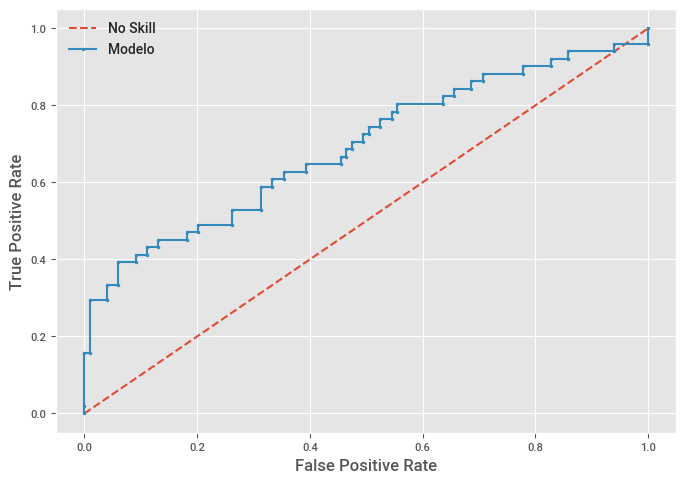

In [164]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]

lr_probs = prob_lgr

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Modelo: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)


plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Modelo')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

In [165]:
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [167]:
X_test_df = pd.DataFrame(X_test,columns=['EDAD', 'ANIOS_AFILIACION', 'CPM', 'TP', 'TXTS', 'ESTADO_CIVIL_C',
       'ESTADO_CIVIL_D', 'ESTADO_CIVIL_S', 'ESTADO_CIVIL_V', 'SEXO_F',
       'SEXO_M', 'MEDIO_PAGO_Cualquiera', 'MEDIO_PAGO_Efectivo',
       'MEDIO_PAGO_tc'])
X_test_df.head(3)

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc
0,0.136364,-1.5,0.351742,1.867647,-0.4,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0
1,-0.636364,-1.0,0.073067,0.691176,-0.2,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.090909,-1.0,-0.705183,-0.632353,-0.2,-1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0


In [168]:
y_test_df = pd.DataFrame(y_test,columns=['TARGET'])
y_test_df.head(3)

,TARGET
0,0
1,0
2,0


In [169]:
data_test_df = pd.concat([X_test_df,y_test_df],axis=1)
data_test_df.head(3)

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc,TARGET
0,0.136364,-1.5,0.351742,1.867647,-0.4,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0
1,-0.636364,-1.0,0.073067,0.691176,-0.2,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.090909,-1.0,-0.705183,-0.632353,-0.2,-1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0


In [170]:
# Add prediction probability to dataframe
data_test_df['pred_proba'] = prob_lgr
data_test_df.head(3)

,EDAD,ANIOS_AFILIACION,CPM,TP,TXTS,ESTADO_CIVIL_C,ESTADO_CIVIL_D,ESTADO_CIVIL_S,ESTADO_CIVIL_V,SEXO_F,SEXO_M,MEDIO_PAGO_Cualquiera,MEDIO_PAGO_Efectivo,MEDIO_PAGO_tc,TARGET,pred_proba
0,0.136364,-1.5,0.351742,1.867647,-0.4,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0,0.086467
1,-0.636364,-1.0,0.073067,0.691176,-0.2,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.192805
2,-0.090909,-1.0,-0.705183,-0.632353,-0.2,-1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,-1.0,0,0.113708


In [171]:
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(data_test_df['TARGET'], data_test_df['pred_proba'])
threshold

[0.28631484644751093]